# core

> Fill in a module description here

In [1]:
#|default_exp core

In [69]:
#|export
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib import cm
import numpy as np
import colorsys
import math
import cmath
import mpmath

In [70]:
#|hide
from nbdev.showdoc import *
from fastcore.test import test_eq

In [71]:
#|export
def cplot3d(f):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ur = np.arange(-2, 2, 0.01)
    vr = np.arange(-2, 2, 0.01)
    u, v = np.meshgrid(ur, vr)

    c = u + 1j * v

    vf = np.vectorize(f)

    r = vf(c)

    print(type(r[0, 0]))
    # scale colors so that they are in [0,1]
    cv = (np.angle(r)/math.pi+1)/2
    
    r[np.abs(r)>10] = np.nan
    ax.set_zlim(top=10)
    ax.plot_surface(u, v, np.abs(r), facecolors=cm.rainbow(cv), alpha = 0.5)

    plt.show()

In [72]:
#|export
def abs_plot(fs, titles, **kwargs):
    if not isinstance(fs, list):
        fs, titles = [fs], [titles] 
    count = len(fs)
    ns = range(1, count+1)
    fig = plt.figure( figsize=(9,3))
    for n, f, title in zip(ns, fs, titles):
        ax = fig.add_subplot(1, count, n, projection='3d')
        do_abs_plot(ax, f, title, **kwargs)

In [111]:
#|export
def phase_plot(
                 f,                  # the function to be plotted.
                 *,                  # ???
                 cmod = cmath,       # the module to be used for complex numbers
                 title = None,       # a title for the plot
                 axes = None,        # axes, if a subplot has already been allocated
                 imagesz = 3,        # images size, if axes have not been specified
                 re=[-5,5],          # range for the real axis
                 im=[-5,5],          # range for the imaginary axis
                 points=2000,        # the approximate number of 'pixels' in the plotted image
                 color=None,
                 verbose=False
            ):
    """A 2D depiction of a rectangular area of the domain of the function using colour 
    to indicate the phase of the output of the function, 
    with brightness indicating the magnitude.
    """
    if axes is None:
        _, axes = plt.subplots(ncols=1, figsize=(imagesz, imagesz))
    cshim = get_shim(cmod)
    color = default_color_function
    rea, reb = re
    ima, imb = im
    dre = reb - rea
    dim = imb - ima
    M = int(math.sqrt(points*dre/dim)+1)
    N = int(math.sqrt(points*dim/dre)+1)
    x = np.linspace(rea, reb, M)
    y = np.linspace(ima, imb, N)
    # Note: we have to be careful to get the right rotation.
    # Test with these plots:
    #   cplot(lambda z: z if z.real < 0 else 0)
    #   cplot(lambda z: z if z.imag < 0 else 0)
    w = np.zeros((N, M, 3))
    for n in range(N):
        for m in range(M):
            z = cshim.new(x[m], y[n])
            try:
                v = color(cshim, f(z))
            except:
                v = (0.1, 0.5, 0.5)
            w[n,m] = v
        if verbose:
            print(str(n) + ' of ' + str(N))
    rea, reb, ima, imb = [float(_) for _ in [rea, reb, ima, imb]]
    axes.imshow(w, extent=(rea, reb, ima, imb), origin='lower')
    if not(title is None):
        axes.set_title(title, fontsize=20)
    return axes

When using the default colour function, the complex plane itself looks like this. Plotted points get lighter as their magnitude increases.

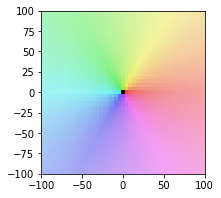

In [134]:
ax = phase_plot(lambda z: z, re=[-100,100], im=[-100,100])

The function should return the axes object that was used, so that the plot can be further embellished.

In [135]:
#|hide
test_eq(str(type(ax)), '<class \'matplotlib.axes._subplots.AxesSubplot\'>')

The function to be plotted can be formulated using complex functions from cmath, mpmath or np. The module can be specified using the `cmod` argument.

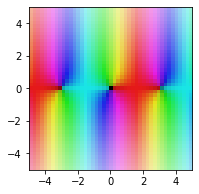

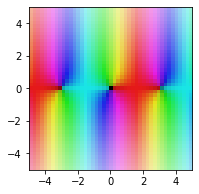

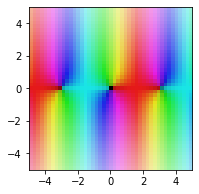

In [148]:
#| hide
(ax1, ax2, ax3) = (phase_plot(lambda z: cmath.sin(z), cmod = cmath), 
                   phase_plot(lambda z: mpmath.sin(z)), 
                   phase_plot(lambda z: np.sin(z)))

Using the default color map, if the output of the function is 'nan', the plotted point will be grey. If the output of the function is infinite, the result will be white.

/tmp/ipykernel_82582/845096383.py:4: RuntimeWarning: divide by zero encountered in cdouble_scalars
  return z/0.0


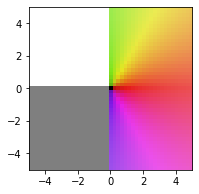

In [153]:
def f1(z):
    if z.real < 0:
        if z.imag > 0:
            return z/0.0
        else:
            return cmath.nan
    else:
        return z

ax = phase_plot(f1)

In [147]:
#|export
def phase_plot_array(
               fs,                 # the funtion(s) to plot
               titles,             # the titles for each plot
               *,
               imagesz=3,          # the size of each image (units???)
               **kwargs            # remaining keyword arguments are passed to `phase_plot`
              ):
    """A convenience function allowing several phase plots to be displayed side by side"""
    if not isinstance(fs, list):
        fs, titles = [fs], [titles] 
    count = len(fs)
    fig, axes = plt.subplots(ncols=count, figsize=(count*imagesz, imagesz))
    if count==1:
        axes = [axes]
    for ax, f, t in zip(axes, fs, titles):
        phase_plot(f, title=t, axes=ax, points=2000)

In [140]:
#|exporti
def default_color_function(shim, z):
    if shim.isinf(z):
        return (1.0, 1.0, 1.0)
    if shim.isnan(z):
        return (0.5, 0.5, 0.5)
    a = (float(shim.arg(z)) + math.pi) / (2*math.pi)
    a = (a + 0.5) % 1.0
    b = 1.0 - float(1/(1.0+abs(z)**0.3))
    return colorsys.hls_to_rgb(a, b, 0.8)

In [141]:
#|exporti
def do_abs_plot(axes, f, title, max_im = 6.3):
    ctx = mpmath
    X = np.arange(-6.3, 5.3, 0.125)
    Y = np.arange(-max_im, max_im, 0.125)
    X, Y = np.meshgrid(X, Y)
    xn, yn = X.shape
    W = X*0
    for xk in range(xn):
        for yk in range(yn):
            ctx.mpc(X[xk,yk], Y[xk,yk])
            z = complex(X[xk,yk], Y[xk,yk])
            w = abs(f(z))
            W[xk,yk] = w
    axes.plot_wireframe(X, Y, W, rstride=5, cstride=5)
    axes.view_init(30, 315)
    axes.set_title(title, fontsize=20)

In [142]:
#| exporti
class ComplexShim:
    def __init__(self, cmod):
        if cmod == cmath:
            self.new = lambda r, i: r + 1j*i
            self.arg = cmath.phase
            self.isnan = cmath.isnan
            self.isinf = cmath.isinf
        elif cmod == mpmath:
            self.new = lambda r, i: mpmath.mpc(r, i)
            self.arg = mpmath.arg
            self.isnan = mpmath.isnan
            self.isinf = mpmath.isinf
        elif cmod == np:
            self.new = lambda r, i: r + 1j*i
            self.arg = cmath.phase
            self.isnan = cmath.isnan
            self.isinf = cmath.isinf
        else:
            raise Exception('todo')

def get_shim(cmod):
    return ComplexShim(cmod)

In [143]:
#| hide
import nbdev; nbdev.nbdev_export()